<a href="https://colab.research.google.com/github/RamanVer1ma/AgroFarm/blob/main/crop_yield_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import ee

# Authenticate and initialize GEE
ee.Authenticate()
ee.Initialize(project='agrofram')

# Define the region and time range
ludhiana = ee.Geometry.Point([75.8573, 30.9000])
start_date = '2015-01-01'
end_date = '2023-01-01'

# Function to compute vegetation indices
def add_indices(image):
    ndvi = image.normalizedDifference(['B5', 'B4']).rename('NDVI')
    evi = image.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))',
        {'NIR': image.select('B5'), 'RED': image.select('B4'), 'BLUE': image.select('B2')}
    ).rename('EVI')
    lswi = image.normalizedDifference(['B5', 'B6']).rename('LSWI')

    return image.addBands([ndvi, evi, lswi])

# Load Landsat 8 data and apply function
landsat = (ee.ImageCollection('LANDSAT/LC08/C02/T1_TOA')
           .filterBounds(ludhiana)
           .filterDate(start_date, end_date)
           .map(add_indices)
           .select(['NDVI', 'EVI', 'LSWI']))

# Aggregate monthly median values
def monthly_median(image_collection):
    months = ee.List.sequence(1, 12)
    years = ee.List.sequence(2015, 2022)

    def year_month(year, month):
        start = ee.Date.fromYMD(year, month, 1)
        end = start.advance(1, 'month')

        filtered = image_collection.filterDate(start, end)
        median = filtered.median().set({
            'year': year,
            'month': month,
            'date': start.format('YYYY-MM')
        })
        return median

    monthly_images = years.map(lambda year: months.map(lambda month: year_month(year, month))).flatten()
    return ee.ImageCollection(monthly_images)

# Get the monthly NDVI, EVI, LSWI
monthly_indices = monthly_median(landsat)

# Convert to Feature Collection for Export
def image_to_feature(image):
    feature = ee.Feature(ludhiana, image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=ludhiana,
        scale=30
    )).set('date', image.get('date'))
    return feature

indices_fc = monthly_indices.map(image_to_feature)

# Export to CSV
task = ee.batch.Export.table.toDrive(
    collection=indices_fc,
    description="Ludhiana_NDVI_EVI_LSWI",
    fileFormat="CSV"
)
task.start()

print("Exporting to Google Drive. Check Google Earth Engine Tasks tab for progress.")


Exporting to Google Drive. Check Google Earth Engine Tasks tab for progress.


In [6]:
import pandas as pd

# Load weather dataset
weather_df = pd.read_csv("/content/Ludhiana_Mango_Yield_Dataset.csv")

# Load remote sensing data
remote_sensing_df = pd.read_csv("/content/Ludhiana_NDVI_EVI_LSWI.csv")

# Convert 'date' column to datetime for proper merging
weather_df["Date"] = pd.to_datetime(weather_df["Date"])
remote_sensing_df["date"] = pd.to_datetime(remote_sensing_df["date"])

# Merge on 'date'
merged_df = pd.merge(weather_df, remote_sensing_df, left_on="Date", right_on="date", how="inner")

# Drop duplicate date column
merged_df.drop(columns=["date"], inplace=True)

# Save the final dataset
merged_df.to_csv("Ludhiana_Final_Dataset.csv", index=False)

print("Merged dataset saved as 'Ludhiana_Final_Dataset.csv'")


Merged dataset saved as 'Ludhiana_Final_Dataset.csv'


In [7]:
from google.colab import files
files.download("Ludhiana_Final_Dataset.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
df=pd.read_csv('/content/Ludhiana_Final_Dataset.csv')

In [28]:
df.head()

,Date,Monthly Rainfall (Prec),Minimum Temperature (Tmin),Maximum Temperature (Tmax),Solar Radiation (Rad),Evapotranspiration (ETo),Vapor Pressure Deficit (VPD),Mango Yield (t/ha),system:index,EVI,LSWI,NDVI,.geo
0,2015-01-01,118.616634,16.413115,30.085447,10.560223,125.061475,2.302316,15.230623,0,0.196050,0.154761,0.038022,"{""type"":""Point"",""coordinates"":[75.8573,30.9]}"
1,2015-02-01,285.707149,10.381287,30.238144,22.339008,130.683474,0.590893,26.181923,1,0.033595,0.037160,0.041973,"{""type"":""Point"",""coordinates"":[75.8573,30.9]}"
2,2015-03-01,222.278243,11.618371,35.889335,15.402860,149.050514,1.061926,22.236539,2,0.131863,0.166782,0.096008,"{""type"":""Point"",""coordinates"":[75.8573,30.9]}"
3,2015-04-01,183.610960,10.471438,38.456654,11.905908,91.261768,2.400823,22.648742,3,0.071384,0.034358,0.072693,"{""type"":""Point"",""coordinates"":[75.8573,30.9]}"
4,2015-05-01,55.245406,19.546156,38.306296,17.833649,87.201809,2.280528,15.004883,4,0.077681,0.019969,0.074965,"{""type"":""Point"",""coordinates"":[75.8573,30.9]}"


In [30]:
df.columns

Index(['Date', 'Monthly Rainfall (Prec)', 'Minimum Temperature (Tmin)',
       'Maximum Temperature (Tmax)', 'Solar Radiation (Rad)',
       'Evapotranspiration (ETo)', 'Vapor Pressure Deficit (VPD)',
       'Mango Yield (t/ha)', 'EVI', 'LSWI', 'NDVI'],
      dtype='object')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Date                          96 non-null     object 
 1   Monthly Rainfall (Prec)       96 non-null     float64
 2   Minimum Temperature (Tmin)    96 non-null     float64
 3   Maximum Temperature (Tmax)    96 non-null     float64
 4   Solar Radiation (Rad)         96 non-null     float64
 5   Evapotranspiration (ETo)      96 non-null     float64
 6   Vapor Pressure Deficit (VPD)  96 non-null     float64
 7   Mango Yield (t/ha)            96 non-null     float64
 8   system:index                  96 non-null     int64  
 9   EVI                           95 non-null     float64
 10  LSWI                          95 non-null     float64
 11  NDVI                          95 non-null     float64
 12  .geo                          96 non-null     object 
dtypes: floa

In [34]:
df.head()

,Monthly Rainfall (Prec),Minimum Temperature (Tmin),Maximum Temperature (Tmax),Solar Radiation (Rad),Evapotranspiration (ETo),Vapor Pressure Deficit (VPD),Mango Yield (t/ha),system:index,EVI,LSWI,NDVI,.geo,Year,Month
0,118.616634,16.413115,30.085447,10.560223,125.061475,2.302316,15.230623,0,0.196050,0.154761,0.038022,"{""type"":""Point"",""coordinates"":[75.8573,30.9]}",2015,1
1,285.707149,10.381287,30.238144,22.339008,130.683474,0.590893,26.181923,1,0.033595,0.037160,0.041973,"{""type"":""Point"",""coordinates"":[75.8573,30.9]}",2015,2
2,222.278243,11.618371,35.889335,15.402860,149.050514,1.061926,22.236539,2,0.131863,0.166782,0.096008,"{""type"":""Point"",""coordinates"":[75.8573,30.9]}",2015,3
3,183.610960,10.471438,38.456654,11.905908,91.261768,2.400823,22.648742,3,0.071384,0.034358,0.072693,"{""type"":""Point"",""coordinates"":[75.8573,30.9]}",2015,4
4,55.245406,19.546156,38.306296,17.833649,87.201809,2.280528,15.004883,4,0.077681,0.019969,0.074965,"{""type"":""Point"",""coordinates"":[75.8573,30.9]}",2015,5


In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso



df = pd.read_csv("Ludhiana_Final_Dataset.csv")
df = df.drop(columns=["system:index", ".geo", "geometry"], errors="ignore")


df["Date"] = pd.to_datetime(df["Date"])


df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month


df = df.drop(columns=["Date"], errors="ignore")


df.fillna(df.median(), inplace=True)


z_scores = np.abs((df - df.mean()) / df.std())
df = df[(z_scores < 3).all(axis=1)]  # to  Keep only values within 3 standard deviations


df["P1_NDVI"] = df[df["Month"].isin([12, 1, 2, 3])]["NDVI"].mean()
df["P2_NDVI"] = df[df["Month"].isin([4, 5, 6, 7])]["NDVI"].mean()

df["P1_EVI"] = df[df["Month"].isin([12, 1, 2, 3])]["EVI"].mean()
df["P2_EVI"] = df[df["Month"].isin([4, 5, 6, 7])]["EVI"].mean()

df["P1_LSWI"] = df[df["Month"].isin([12, 1, 2, 3])]["LSWI"].mean()
df["P2_LSWI"] = df[df["Month"].isin([4, 5, 6, 7])]["LSWI"].mean()


df = df.drop(columns=["NDVI", "EVI", "LSWI", "Month"], errors="ignore")

# Feature Scaling
scaler = StandardScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])


train_cty = df[df["Year"] < df["Year"].max()]  # will Train on all years except last one
test_cty = df[df["Year"] == df["Year"].max()]  # will Test  on the last year

# Train-Test Split using LOYO (Leave-One-Year-Out)
train_loyo, test_loyo = train_test_split(df, test_size=1/len(df["Year"].unique()), shuffle=False)


train_cty = train_cty.drop(columns=["Year"], errors="ignore")
test_cty = test_cty.drop(columns=["Year"], errors="ignore")
train_loyo = train_loyo.drop(columns=["Year"], errors="ignore")
test_loyo = test_loyo.drop(columns=["Year"], errors="ignore")


train_cty.to_csv("Ludhiana_Train_CTY.csv", index=False)
test_cty.to_csv("Ludhiana_Test_CTY.csv", index=False)
train_loyo.to_csv("Ludhiana_Train_LOYO.csv", index=False)
test_loyo.to_csv("Ludhiana_Test_LOYO.csv", index=False)

print(" Preprocessing Complete. Cleaned datasets saved!")


✅ Preprocessing Complete. Cleaned datasets saved!


In [42]:
from google.colab import files
files.download("Ludhiana_Train_CTY.csv")
files.download("Ludhiana_Test_CTY.csv")
files.download("Ludhiana_Train_LOYO.csv")
files.download("Ludhiana_Test_LOYO.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [43]:

train_cty = pd.read_csv("Ludhiana_Train_CTY.csv")
test_cty = pd.read_csv("Ludhiana_Test_CTY.csv")

# Spliting features and target variable
X_train = train_cty.drop(columns=["Mango Yield (t/ha)"])
y_train = train_cty["Mango Yield (t/ha)"]
X_test = test_cty.drop(columns=["Mango Yield (t/ha)"])
y_test = test_cty["Mango Yield (t/ha)"]


models = {
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR": SVR(kernel='rbf', C=100, gamma=0.1),
    "XGBoost": XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.1)
}


for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    joblib.dump(model, f"{name}_model.pkl")
    print(f"{name} model saved.\n")

print(" All models trained and saved successfully!")


Training RandomForest...
RandomForest model saved.

Training SVR...
SVR model saved.

Training XGBoost...
XGBoost model saved.

Training Ridge...
Ridge model saved.

Training Lasso...
Lasso model saved.

✅ All models trained and saved successfully!


          Model       MAE      NMAE      FLEM  R² Score
0  RandomForest  0.264135  0.966554 -0.156650  0.746978
1           SVR  0.287005  1.050242 -0.015609  0.685657
2       XGBoost  0.274194  1.003364 -0.166416  0.728014
3         Ridge  0.121530  0.444717 -0.019536  0.936854
4         Lasso  0.174111  0.637128 -0.036079  0.891350
✅ Model evaluation complete. Results saved!


<Figure size 1200x600 with 0 Axes>

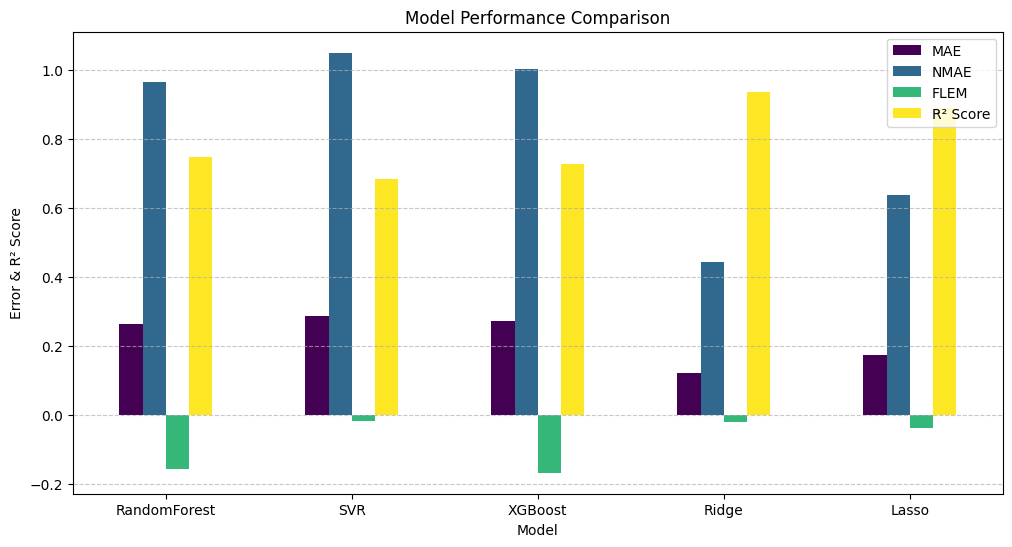

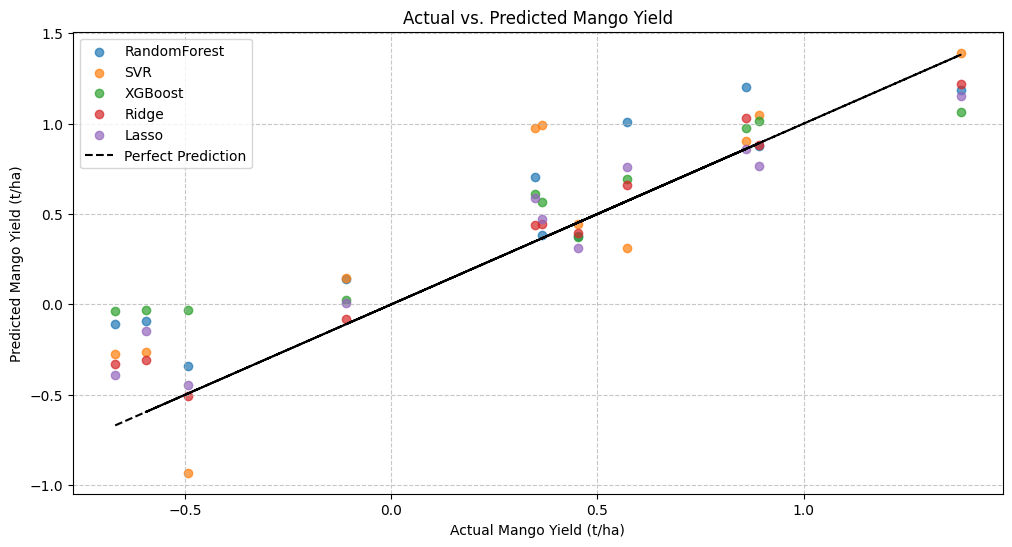

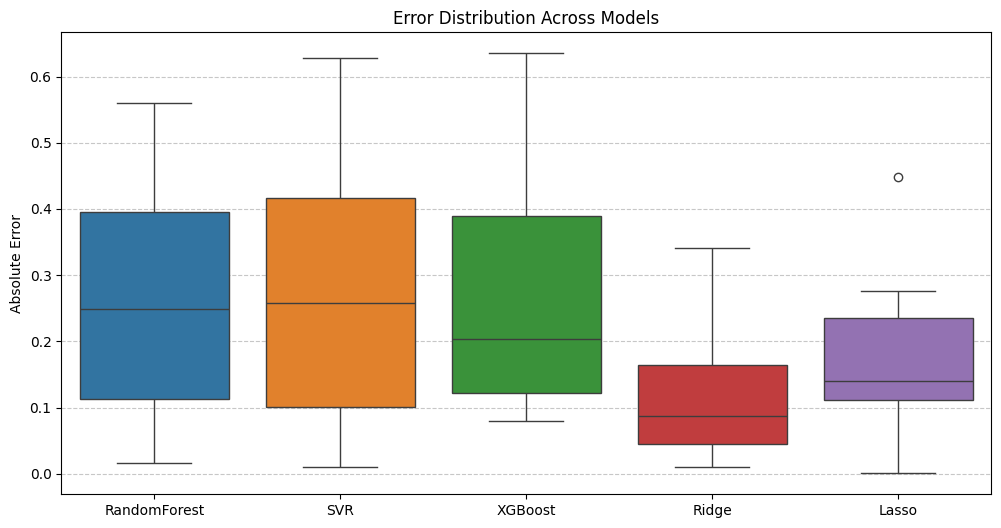

<ipython-input-46-d066551df99c>:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=results_df["Model"], y=results_df["R² Score"], palette="coolwarm")


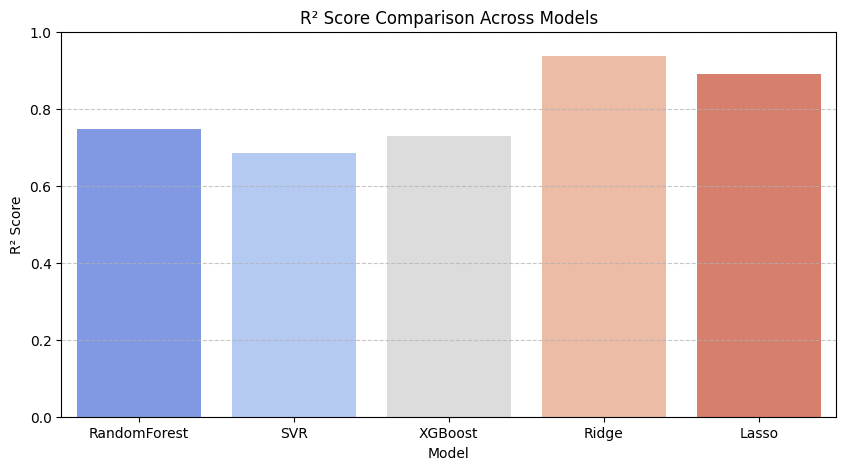

In [46]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


test_cty = pd.read_csv("Ludhiana_Test_CTY.csv")
X_test = test_cty.drop(columns=["Mango Yield (t/ha)"])
y_test = test_cty["Mango Yield (t/ha)"]

# Loading trained models
models = {
    "RandomForest": joblib.load("RandomForest_model.pkl"),
    "SVR": joblib.load("SVR_model.pkl"),
    "XGBoost": joblib.load("XGBoost_model.pkl"),
    "Ridge": joblib.load("Ridge_model.pkl"),
    "Lasso": joblib.load("Lasso_model.pkl")
}

# Define custom NMAE and FLEM metrics
def normalized_mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred) / np.mean(y_true)

def flem_metric(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / (y_true + 1e-6))  # To Avoid division by zero


results = []
predictions = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    nmae = normalized_mae(y_test, y_pred)
    flem = flem_metric(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append([name, mae, nmae, flem, r2])
    predictions[name] = y_pred

results_df = pd.DataFrame(results, columns=["Model", "MAE", "NMAE", "FLEM", "R² Score"])
print(results_df)


results_df.to_csv("Model_Evaluation_Results.csv", index=False)
print("Model evaluation complete. Results saved!")

#  MAE, NMAE, FLEM, R² Comparison
plt.figure(figsize=(12, 6))
results_df.set_index("Model").plot(kind="bar", figsize=(12, 6), colormap="viridis")
plt.title("Model Performance Comparison")
plt.ylabel("Error & R² Score")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(["MAE", "NMAE", "FLEM", "R² Score"])
plt.xticks(rotation=0)
plt.show()

# Sctter plot Actual vs. Predicted Yield
plt.figure(figsize=(12, 6))
for name, y_pred in predictions.items():
    plt.scatter(y_test, y_pred, label=name, alpha=0.7)
plt.plot(y_test, y_test, color="black", linestyle="--", label="Perfect Prediction")
plt.xlabel("Actual Mango Yield (t/ha)")
plt.ylabel("Predicted Mango Yield (t/ha)")
plt.title("Actual vs. Predicted Mango Yield")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()

#  Box Plot - Error Distribution
error_df = pd.DataFrame({name: np.abs(y_test - y_pred) for name, y_pred in predictions.items()})
plt.figure(figsize=(12, 6))
sns.boxplot(data=error_df)
plt.title("Error Distribution Across Models")
plt.ylabel("Absolute Error")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


plt.figure(figsize=(10, 5))
sns.barplot(x=results_df["Model"], y=results_df["R² Score"], palette="coolwarm")
plt.title("R² Score Comparison Across Models")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
